# Hospital Readmission Risk Prediction

**Goal**: *Predict whether a patient will be readmitted within 30 days of discharge.*

**Dataset**: *100k+ hospital encounters (UCI Diabetes 130-US hospitals dataset)*

In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## Load and Inspect Data

In [2]:
DATA_CSV = "diabetic_data.csv"    # main dataset
IDS_MAP_CSV = "IDS_mapping.csv"   # mapping for admission_type_id (adjust if different)
CLEANED_OUT = "cleaned_readmission_data.csv"
ENCODINGS_OUT = "categorical_encodings.json"

In [3]:
# Load data
data = pd.read_csv("data/" + DATA_CSV)
ids_map =  pd.read_csv("data/" + IDS_MAP_CSV)
df = data.copy()
print(f"Dataset Shape: {df.shape}")
display(df.head())

Dataset Shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Data Info summary
print("Dataset Info:", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [5]:
# Initialize an empty list to store column names with '?'
columns_with_question_mark = []

# Iterate through each column
for col in df.columns:
    # Check if any value in the column contains '?'
    # Convert column to string type to ensure .str accessor works
    if df[col].astype(str).str.contains('\?').any():
        columns_with_question_mark.append(col)

print("Columns containing the character '?':")
print(columns_with_question_mark)

Columns containing the character '?':
['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']


### Data Cleaning & Preparation

In [6]:
# Replace '?' with NaN 
df = df.replace('?', np.nan)
(df.isna().sum()/len(df)*100).sort_values(ascending=False).round(1).head(12)

weight               96.9
max_glu_serum        94.7
A1Cresult            83.3
medical_specialty    49.1
payer_code           39.6
race                  2.2
diag_3                1.4
diag_2                0.4
diag_1                0.0
encounter_id          0.0
troglitazone          0.0
tolbutamide           0.0
dtype: float64

In [ ]:
# ---------- Basic hygiene ----------
# Replace '?' placeholders with NaN
df = df.replace('?', np.nan)

# Drop identifiers and columns we decided are too sparse
df = df.drop(columns=['encounter_id', 'patient_nbr'], errors='ignore')

# Drop weight and max_glu_serum (very high missingness)
df = df.drop(columns=['weight', 'max_glu_serum', 'payer_code'], errors='ignore')

# A1Cresult: keep, fill missing as 'None' to preserve indicator that no test was done
df['A1Cresult'] = df['A1Cresult'].fillna('None')

# Fill some other common missing-values with 'Unknown'
df['medical_specialty'] = df['medical_specialty'].fillna('Unknown')
# df['payer_code'] = df['payer_code'].fillna('Unknown')
df['race'] = df['race'].fillna('Unknown')
df[['diag_2', 'diag_3']] = df[['diag_2', 'diag_3']].fillna('Unknown')

In [8]:
# Merge IDS mapping safely
# Ensure both sides are string (handles NaN safely)
df['admission_type_id'] = df['admission_type_id'].astype(str)
ids_map['admission_type_id'] = ids_map['admission_type_id'].astype(str)

# Merge (left); missing labels become NaN -> fill as 'Unknown'
df = df.merge(ids_map, on='admission_type_id', how='left')

In [9]:
# ---------- Target: binary for <30 days ----------
df['readmit_30'] = df['readmitted'].apply(lambda x: 1 if str(x).strip() == '<30' else 0)
# keep original readmitted if you want; otherwise drop:
df = df.drop(columns=['readmitted'])

In [10]:
# ---------- Age: convert bracket -> numeric midpoint ----------
def age_to_mid(a):
    try:
        a = str(a).strip()
        a = a.strip('[]').strip('()')
        lo, hi = a.split('-')
        return (int(lo) + int(hi)) / 2
    except:
        return np.nan

df['age_num'] = df['age'].apply(age_to_mid)
# keep original age bracket too if desired
# df = df.drop(columns=['age'])

In [11]:
# ---------- 4. Diagnosis grouping (ICD9 prefix -> clinical group) ----------
def diag_group(code):
    try:
        c = float(code)
        if (390 <= c <= 459) or (c == 785):
            return 'circulatory'
        elif (460 <= c <= 519) or (c == 786):
            return 'respiratory'
        elif (520 <= c <= 579) or (c == 787):
            return 'digestive'
        elif 250 <= c < 251:  # diabetes codes 250.xx
            return 'diabetes'
        elif 800 <= c <= 999:
            return 'injury'
        elif 710 <= c <= 739:
            return 'musculoskeletal'
        elif (580 <= c <= 629) or (c == 788):
            return 'genitourinary'
        elif 140 <= c <= 239:
            return 'neoplasms'
        else:
            return 'other'
    except:
        # non-numeric or NaN
        return 'unknown'

for col in ['diag_1', 'diag_2', 'diag_3']:
    if col in df.columns:
        df[col+'_group'] = df[col].apply(diag_group)

# Optionally drop raw diag columns (ICD codes)
df = df.drop(columns=[c for c in ['diag_1','diag_2','diag_3'] if c in df.columns])

In [12]:
# ---------- Medication encoding (No/Steady/Up/Down -> ints) ----------
med_start = 'metformin'  # first med column name in dataset
# identify med columns dynamically from known column names list
med_cols = [
    'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
    'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
    'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
    'examide','citoglipton','insulin','glyburide-metformin',
    'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone',
    'metformin-pioglitazone'
]
med_cols = [c for c in med_cols if c in df.columns]

def med_to_int(val):
    if pd.isna(val):
        return 0
    v = str(val).strip().lower()
    if v in ['no', 'none']:
        return 0
    if v in ['steady', 'steady.']:
        return 1
    if v in ['up', 'up.']:
        return 2
    if v in ['down', 'down.']:
        return -1
    # fallback
    return 0

for c in med_cols:
    df[c+'_code'] = df[c].apply(med_to_int)
# optional: drop original med columns
df = df.drop(columns=med_cols)

In [13]:
# synthetic medication features
med_code_cols = [c for c in df.columns if c.endswith('_code')]
df['num_meds_changed'] = df[med_code_cols].apply(lambda row: ((row==2) | (row==-1)).sum(), axis=1)
df['any_med_change'] = (df['num_meds_changed'] > 0).astype(int)

# map 'change' column to binary (common values: 'Ch' or 'No' in dataset)
if 'change' in df.columns:
    df['change_flag'] = (~df['change'].astype(str).str.lower().isin(['no','no change','none'])).astype(int)
    df = df.drop(columns=['change'])

# diabetesMed -> binary
if 'diabetesMed' in df.columns:
    df['diabetesMed_flag'] = df['diabetesMed'].astype(str).str.lower().map({'yes':1,'no':0}).fillna(0).astype(int)
    df = df.drop(columns=['diabetesMed'])

In [14]:
# ---------- Useful aggregated features ----------
df['prev_visits'] = df[['number_outpatient','number_emergency','number_inpatient']].sum(axis=1)
df['polypharmacy'] = (df['num_medications'] > 10).astype(int)
df['multi_diag'] = (df['number_diagnoses'] > 8).astype(int)
df['on_insulin'] = (df[[c for c in df.columns if c.endswith('insulin_code') or c.startswith('insulin')]].sum(axis=1) > 0).astype(int) \
    if any(c for c in df.columns if 'insulin' in c) else 0

In [15]:
# ---------- Categorical treatment: keep readable strings, then factorize ----------
# select categorical columns to factorize (we keep label versions for interpretability)
cat_cols = [
    'race','gender','medical_specialty','admission_type_label',
    'discharge_disposition_id','admission_source_id','payer_code',
    'A1Cresult','diag_1_group','diag_2_group','diag_3_group'
]
cat_cols = [c for c in cat_cols if c in df.columns]

categorical_mappings = {}
for c in cat_cols:
    # fill na just in case
    df[c] = df[c].fillna('Unknown').astype(str)
    codes, uniques = pd.factorize(df[c], sort=True)
    df[c + '_enc'] = codes
    # store mapping list for later reverse-lookup
    categorical_mappings[c] = list(uniques)

In [16]:
# drop original categorical raw columns if you prefer final dataset compactness
# (we keep label columns + encoded columns; drop raw if not needed)
# df = df.drop(columns=[c for c in cat_cols])  


In [17]:
# ---------- 8. Final column selection ----------
# choose features to keep for modeling (example)
keep_cols = [
    'age_num','time_in_hospital','num_lab_procedures','num_procedures','num_medications',
    'number_outpatient','number_emergency','number_inpatient','number_diagnoses',
    'num_meds_changed','any_med_change','prev_visits','polypharmacy','multi_diag',
    'diabetesMed_flag','on_insulin'
]
# include encoded categorical columns
keep_cols += [c + '_enc' for c in cat_cols if (c + '_enc') in df.columns]
# include med_code columns
keep_cols += med_code_cols

In [18]:
# remove any duplicates and ensure cols exist
keep_cols = [c for c in keep_cols if c in df.columns]
X = df[keep_cols].copy()
y = df['readmit_30'].copy()

In [19]:
# ---------- Train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ---------- Save cleaned dataset and encodings ----------
df_to_save = pd.concat([X, y], axis=1)
df_to_save.to_csv("/data/"+CLEANED_OUT, index=False)

In [20]:
import json
import os

# save categorical mappings for later inverse-transform / interpretation
with open(ENCODINGS_OUT, 'w') as f:
    json.dump(categorical_mappings, f, indent=2)

print("Preprocessing complete.")
print("Cleaned dataset saved to:", CLEANED_OUT)
print("Categorical encodings saved to:", ENCODINGS_OUT)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

Preprocessing complete.
Cleaned dataset saved to: cleaned_readmission_data.csv
Categorical encodings saved to: categorical_encodings.json
X_train shape: (244238, 48) X_test shape: (61060, 48)


## Exploratory Data Analysis (EDA)

In [21]:
# Dataset shape and preview
print(f"Data shape: {df.shape}")
display(df.head())

# Data types summary
df.info()

# Summary stats for numeric columns
df.describe(include='number').T


Data shape: (305298, 62)


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,on_insulin,race_enc,gender_enc,medical_specialty_enc,discharge_disposition_id_enc,admission_source_id_enc,A1Cresult_enc,diag_1_group_enc,diag_2_group_enc,diag_3_group_enc
0,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,41,0,...,0,2,0,37,16,0,2,1,9,9
1,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,41,0,...,0,2,0,37,16,0,2,1,9,9
2,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,41,0,...,0,2,0,37,16,0,2,1,9,9
3,Caucasian,Female,[10-20),1,1,7,3,Unknown,59,0,...,1,2,0,71,0,14,2,7,1,7
4,Caucasian,Female,[10-20),1,1,7,3,Unknown,59,0,...,1,2,0,71,0,14,2,7,1,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305298 entries, 0 to 305297
Data columns (total 62 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   race                           305298 non-null  object 
 1   gender                         305298 non-null  object 
 2   age                            305298 non-null  object 
 3   admission_type_id              305298 non-null  object 
 4   discharge_disposition_id       305298 non-null  object 
 5   admission_source_id            305298 non-null  object 
 6   time_in_hospital               305298 non-null  int64  
 7   medical_specialty              305298 non-null  object 
 8   num_lab_procedures             305298 non-null  int64  
 9   num_procedures                 305298 non-null  int64  
 10  num_medications                305298 non-null  int64  
 11  number_outpatient              305298 non-null  int64  
 12  number_emergency              

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,305298.0,4.395987,2.985098,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,305298.0,43.095641,19.674298,1.0,31.0,44.0,57.0,132.0
num_procedures,305298.0,1.339730,1.705801,0.0,0.0,1.0,2.0,6.0
num_medications,305298.0,16.021844,8.127540,1.0,10.0,15.0,20.0,81.0
number_outpatient,305298.0,0.369357,1.267261,0.0,0.0,0.0,0.0,42.0
number_emergency,305298.0,0.197836,0.930469,0.0,0.0,0.0,0.0,76.0
number_inpatient,305298.0,0.635566,1.262859,0.0,0.0,0.0,1.0,21.0
number_diagnoses,305298.0,7.422607,1.933594,1.0,6.0,8.0,9.0,16.0
readmit_30,305298.0,0.111599,0.314873,0.0,0.0,0.0,0.0,1.0
age_num,305298.0,65.967022,15.940785,5.0,55.0,65.0,75.0,95.0


### Target Variable Distribution

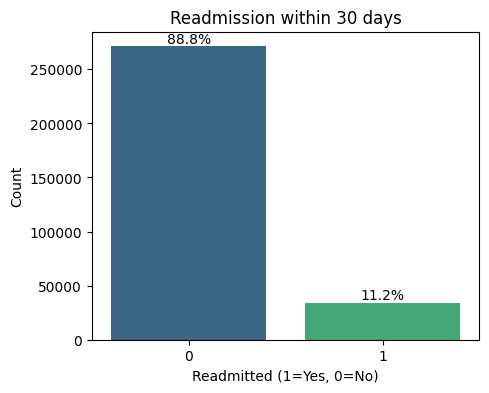

Readmission rate within 30 days: 11.16%


In [22]:
plt.figure(figsize=(5, 4))
ax = sns.countplot(x='readmit_30', data=df, palette='viridis')
plt.title("Readmission within 30 days")
plt.xlabel("Readmitted (1=Yes, 0=No)")
plt.ylabel("Count")

# Calculate total for percentages
total = len(df)

# Add percentage labels to bars
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width() / 2., height + 3,
            f'{percentage:.1f}%', ha="center", va="bottom")

plt.show()

# Numeric summary
readmit_rate = df['readmit_30'].mean()*100
print(f"Readmission rate within 30 days: {readmit_rate:.2f}%")

### Demographics and Readmission Patterns

#### Age Groups

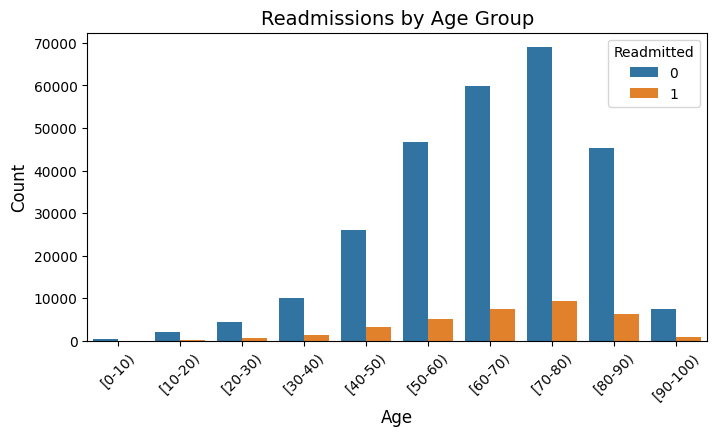

In [23]:
plt.figure(figsize=(8,4))
sns.countplot(x='age', hue='readmit_30', data=df)
plt.title('Readmissions by Age Group', fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Readmitted')
plt.show()

*Readmission risk apears to increase with age up to age group 70-80 then starts to drop. Age group 70-80 has the highest readmission rate.*

#### Race

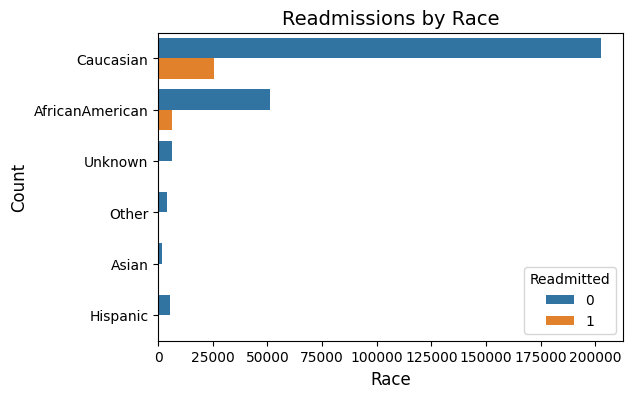

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(y='race', hue='readmit_30', data=df)
plt.title('Readmissions by Race', fontsize=14)
plt.xlabel("Race", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title='Readmitted')
plt.show()

*Caucasian has the highest admission and readmission rate followed by AfricanAmerican*

#### Gender

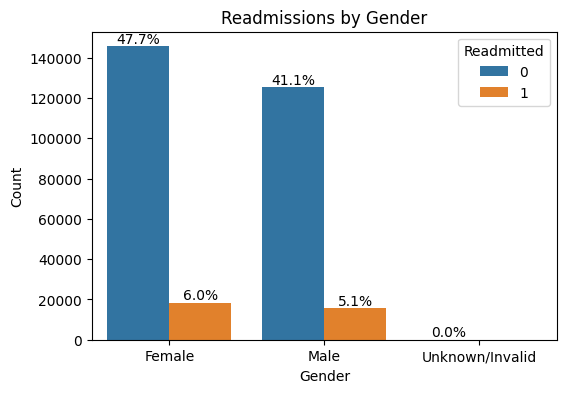

In [25]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='gender', hue='readmit_30', data=df)
plt.title('Readmissions by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Readmitted')

# Compute total counts per gender
totals = df['gender'].value_counts()

# Add percentage labels for each bar
for p in ax.patches:
    height = p.get_height()
    if height == 0:
        continue  # skip empty bars

    # Find which gender this bar belongs to
    x_category = p.get_x() + p.get_width() / 2
    x_index = int(round(x_category))
    gender = ax.get_xticklabels()[x_index].get_text()

    percentage = 100 * height / len(df)
    ax.text(p.get_x() + p.get_width() / 2., height + 3,
            f'{percentage:.1f}%', ha="center", va="bottom")

plt.show()

#### Medical Specialty Insights

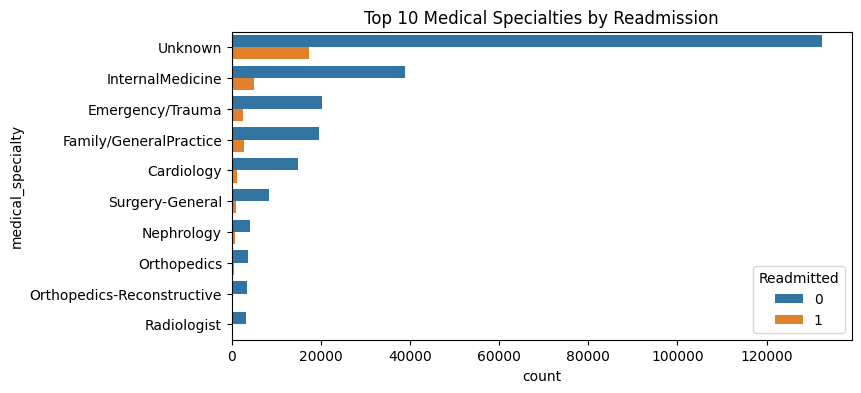

In [26]:
top_specialties = (
    df['medical_specialty']
    .value_counts()
    .head(10)
    .index
)
plt.figure(figsize=(8,4))
sns.countplot(y='medical_specialty', hue='readmit_30',
              data=df[df['medical_specialty'].isin(top_specialties)],
              order=top_specialties)
plt.title('Top 10 Medical Specialties by Readmission')
plt.legend(title='Readmitted')
plt.show()

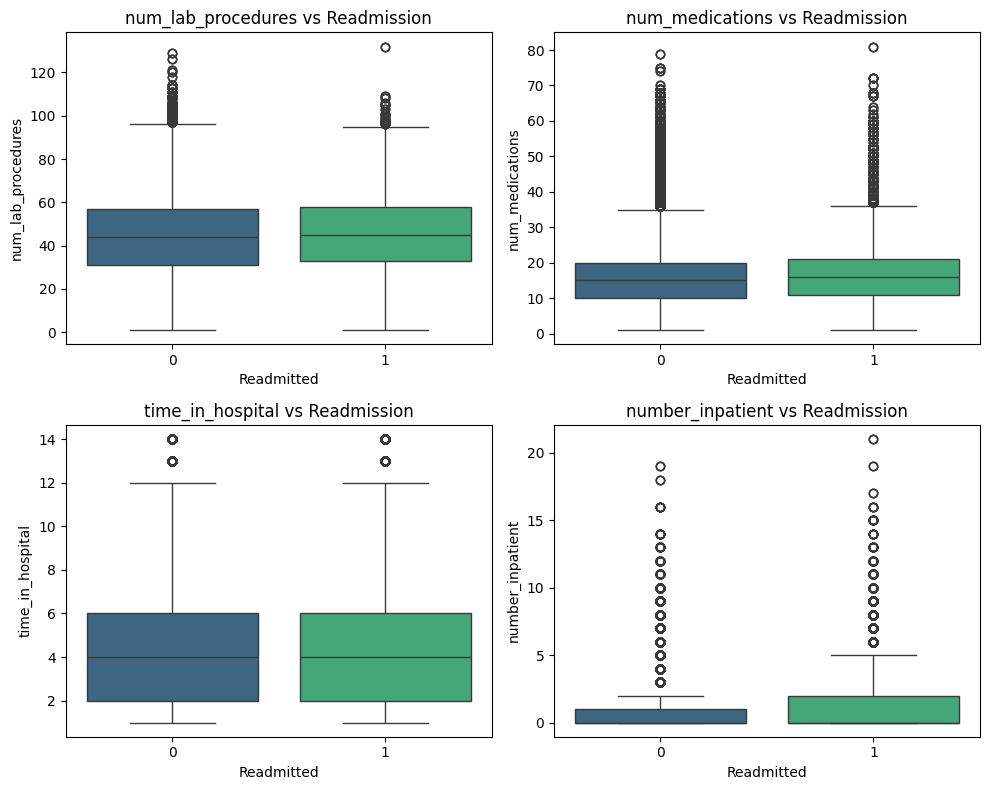

In [27]:
numeric_features = ['num_lab_procedures', 'num_medications', 'time_in_hospital', 'number_inpatient']
# Plot numeric features in a grid (2x2)
n_feats = len(numeric_features)
n_cols = 2
n_rows = int(np.ceil(n_feats / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes_flat = axes.flatten() if n_feats > 1 else [axes]

for i, col in enumerate(numeric_features):
    ax_i = axes_flat[i]
    sns.boxplot(x='readmit_30', y=col, data=df, ax=ax_i, palette='viridis')
    ax_i.set_title(f'{col} vs Readmission')
    ax_i.set_xlabel('Readmitted')
    ax_i.set_ylabel(col)

# Turn off any unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()

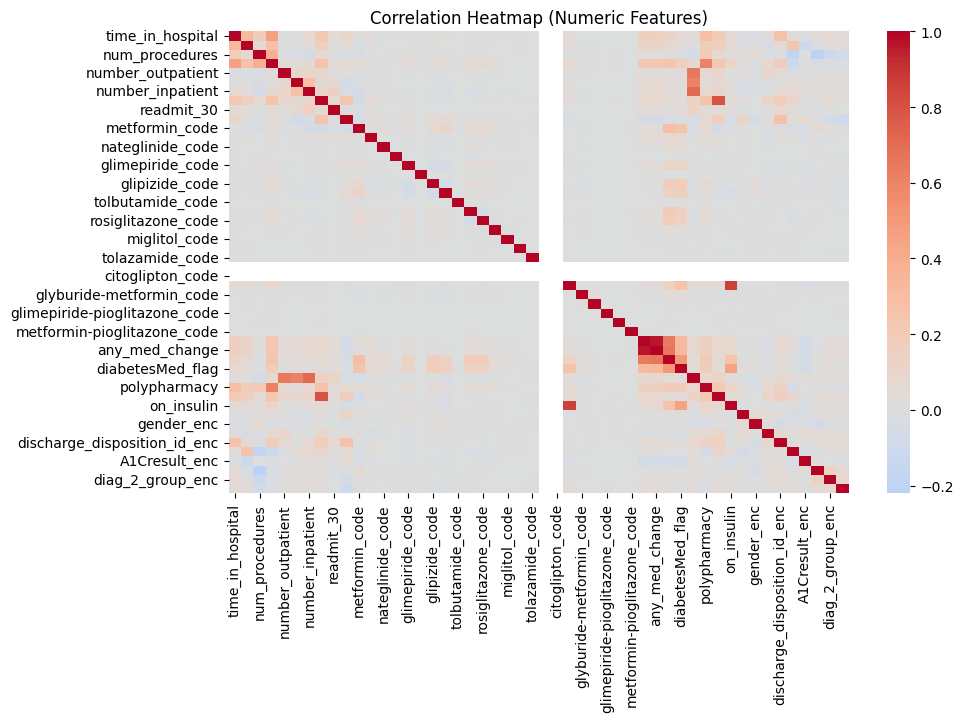

In [30]:
num_cols = df.select_dtypes(include=np.number).columns
corr = df[num_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

### Feature Engineering
#### Diagnosis Grouping


In [31]:
# def diag_group(code):
#     try:
#         c = float(code)
#         if 390 <= c <= 459 or c == 785: return 'circulatory'
#         elif 460 <= c <= 519 or c == 786: return 'respiratory'
#         elif 520 <= c <= 579 or c == 787: return 'digestive'
#         elif 250 <= c < 251: return 'diabetes'
#         elif 800 <= c <= 999: return 'injury'
#         elif 710 <= c <= 739: return 'musculoskeletal'
#         elif 580 <= c <= 629 or c == 788: return 'genitourinary'
#         elif 140 <= c <= 239: return 'neoplasms'
#         else: return 'other'
#     except:
#         return 'unknown'

# for col in ['diag_1','diag_2','diag_3']:
#     df[col+'_group'] = df[col].apply(diag_group)

#### Age Transformation

In [32]:
# def age_to_num(a):
#     lo, hi = a.strip('[]').strip('()').split('-')
#     return (int(lo) + int(hi)) / 2
# df['age_num'] = df['age'].apply(age_to_num)

#### Medication Encoding
Each drug column (e.g. metformin, insulin, etc.) has categorical levels:
`No`, `Steady`, `Up`, `Down`.

Convert to numerical trend signals

In [33]:
# def med_to_int(val):
#     return {'No': 0, 'Steady': 1, 'Up': 2, 'Down': -1}.get(val, 0)

# med_cols = df.columns[24:47]  # medication range in your list
# for col in med_cols:
#     df[col] = df[col].apply(med_to_int)


In [34]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,on_insulin,race_enc,gender_enc,medical_specialty_enc,discharge_disposition_id_enc,admission_source_id_enc,A1Cresult_enc,diag_1_group_enc,diag_2_group_enc,diag_3_group_enc
0,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,41,0,...,0,2,0,37,16,0,2,1,9,9
1,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,41,0,...,0,2,0,37,16,0,2,1,9,9
2,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,41,0,...,0,2,0,37,16,0,2,1,9,9
3,Caucasian,Female,[10-20),1,1,7,3,Unknown,59,0,...,1,2,0,71,0,14,2,7,1,7
4,Caucasian,Female,[10-20),1,1,7,3,Unknown,59,0,...,1,2,0,71,0,14,2,7,1,7


## Modeling

In [35]:
# !pip install shap

In [36]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
import shap

In [37]:
# Handle imbalance automatically using 'balanced' weights
train_weights = y_train.map({0: 1, 1: (len(y_train) - y_train.sum()) / y_train.sum()})

# LightGBM dataset objects
lgb_train = lgb.Dataset(X_train, label=y_train, weight=train_weights)
lgb_val = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# Model parameters
params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42,
    'verbose': -1
}

In [38]:
from lightgbm import early_stopping

# Train model
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50)
    ]
)

# Predictions
y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_prob >= 0.5).astype(int)

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.690309	train's binary_logloss: 0.642937	valid's auc: 0.688338	valid's binary_logloss: 0.643578
[100]	train's auc: 0.703289	train's binary_logloss: 0.629969	valid's auc: 0.697253	valid's binary_logloss: 0.631382
[150]	train's auc: 0.71583	train's binary_logloss: 0.621194	valid's auc: 0.706047	valid's binary_logloss: 0.623909
[200]	train's auc: 0.727426	train's binary_logloss: 0.614152	valid's auc: 0.713688	valid's binary_logloss: 0.618102
[250]	train's auc: 0.737602	train's binary_logloss: 0.607939	valid's auc: 0.720272	valid's binary_logloss: 0.612737
[300]	train's auc: 0.747019	train's binary_logloss: 0.602017	valid's auc: 0.72702	valid's binary_logloss: 0.607445
[350]	train's auc: 0.756114	train's binary_logloss: 0.596099	valid's auc: 0.733045	valid's binary_logloss: 0.603222
[400]	train's auc: 0.76445	train's binary_logloss: 0.590638	valid's auc: 0.738804	valid's binary_logloss: 0.599016
[450]	train's a

ROC-AUC: 0.7503
PR-AUC:  0.2881

Confusion Matrix:
[[37517 16729]
 [ 2223  4591]]

Classification Report:
               precision    recall  f1-score   support

           0      0.944     0.692     0.798     54246
           1      0.215     0.674     0.326      6814

    accuracy                          0.690     61060
   macro avg      0.580     0.683     0.562     61060
weighted avg      0.863     0.690     0.746     61060



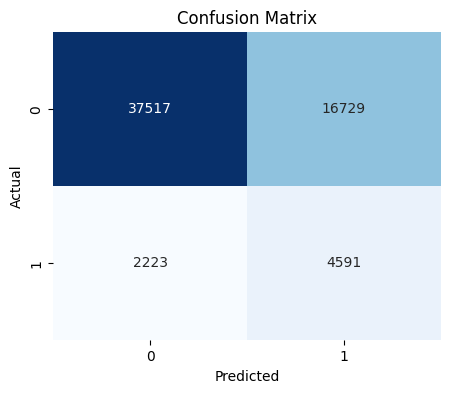

In [39]:
# ---------- Evaluation ----------
roc_auc = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC:  {pr_auc:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:\n", report)

# ---------- Confusion Matrix Plot ----------
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

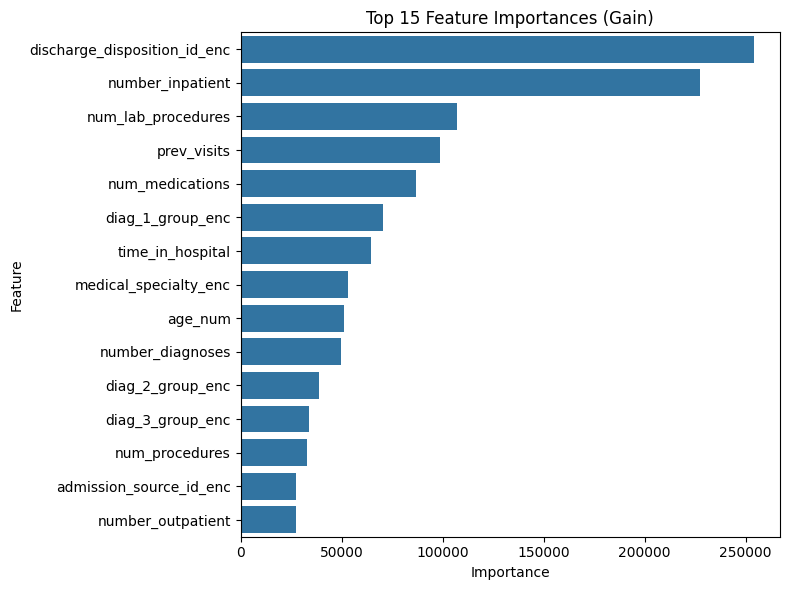

In [40]:
# ---------- Feature Importance ----------
importances = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()
fi = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
fi_df = pd.DataFrame(fi, columns=['Feature','Importance'])

plt.figure(figsize=(8,6))
sns.barplot(data=fi_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

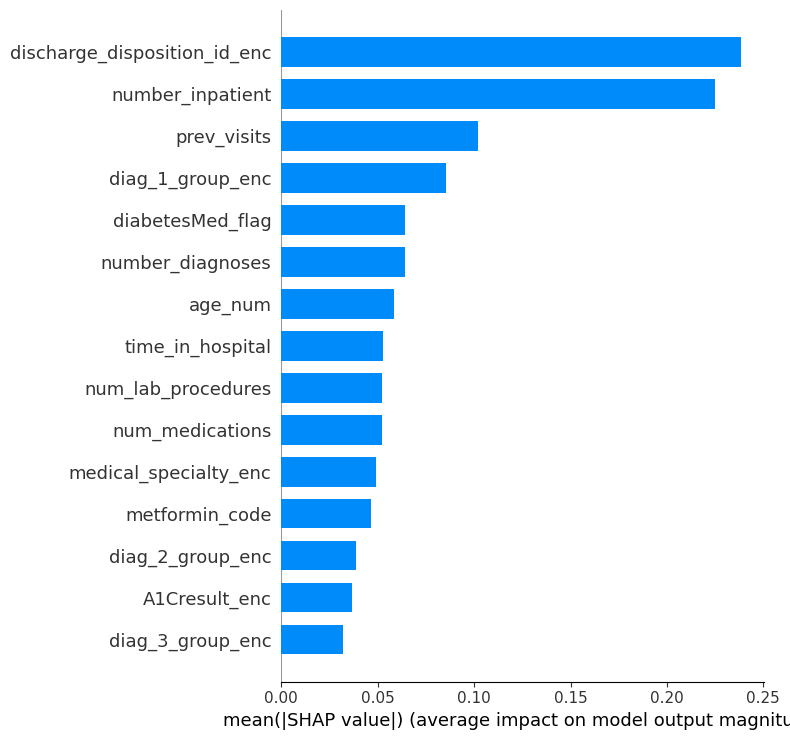

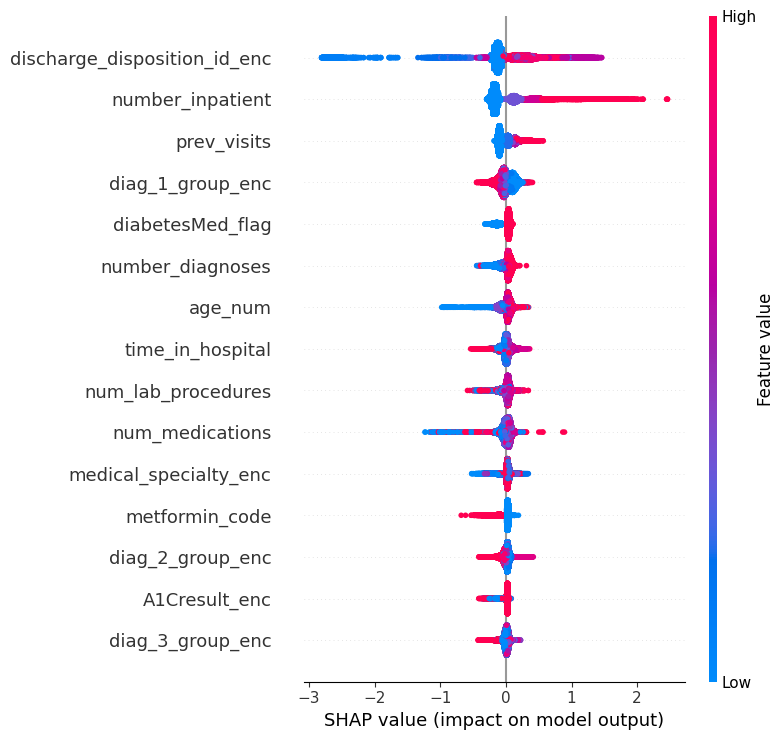

In [41]:
# ---------- SHAP Explainability ----------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Global feature importance (summary plot)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)

# Optional: full beeswarm summary for distribution of impacts
shap.summary_plot(shap_values, X_test, max_display=15)